In [6]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = '/content/drive/MyDrive/trafic_32.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import numpy as np
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader
from torchvision.models import inception_v3
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split
from torchvision import datasets

In [73]:
latent_dim = 100
hidden_dim = 64
image_channels = 3
image_size = 32
num_epochs = 50
batch_size = 128
lr = 0.0002
beta1 = 0.5
display_epoch = 10
val_split = 0.1
data_dir = '/content/trafic_32/trafic_32'
num_classes = 43

In [74]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print(dataset.class_to_idx)

total_size = len(dataset)
val_size = int(total_size * val_split)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

{'00000': 0, '00001': 1, '00002': 2, '00003': 3, '00004': 4, '00005': 5, '00006': 6, '00007': 7, '00008': 8, '00009': 9, '00010': 10, '00011': 11, '00012': 12, '00013': 13, '00014': 14, '00015': 15, '00016': 16, '00017': 17, '00018': 18, '00019': 19, '00020': 20, '00021': 21, '00022': 22, '00023': 23, '00024': 24, '00025': 25, '00026': 26, '00027': 27, '00028': 28, '00029': 29, '00030': 30, '00031': 31, '00032': 32, '00033': 33, '00034': 34, '00035': 35, '00036': 36, '00037': 37, '00038': 38, '00039': 39, '00040': 40, '00041': 41, '00042': 42}


In [75]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [76]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),
            # (hidden_dim*8) x 4 x 4
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            # (hidden_dim*4) x 8 x 8
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # (hidden_dim*2) x 16 x 16
            nn.ConvTranspose2d(hidden_dim * 2, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # image_channels x 32 x 32
        )

    def forward(self, z):
        return self.model(z)

In [77]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # image_channels x 32 x 32
            nn.Conv2d(image_channels, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # hidden_dim x 16 x 16
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_dim*2) x 8 x 8
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_dim*4) x 4 x 4
            nn.Conv2d(hidden_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

In [78]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
adversarial_loss = nn.BCELoss()

In [79]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [80]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [81]:
def show_generated_images(images, epoch):
    images = images.detach().cpu()
    grid = make_grid(images[:16], nrow=4, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.axis('off')
    plt.show()
    save_image(grid, f'generated_epoch_{epoch}.png')

In [82]:
def calculate_fid(real_images, fake_images, batch_size=32):
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    resize = transforms.Resize((299, 299))
    def preprocess(imgs):
        imgs = resize(imgs)
        imgs = (imgs - 0.5) * 2
        return imgs

    def get_features(images, model, batch_size):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            batch = preprocess(batch)
            with torch.no_grad():
                feat = model(batch).detach().cpu().numpy()
            features.append(feat)
        return np.concatenate(features)

    real_features = get_features(real_images, inception, batch_size)
    fake_features = get_features(fake_images, inception, batch_size)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [83]:
def train_gan(train_loader, val_loader):
    os.makedirs('generated_images', exist_ok=True)
    real_label = 0.9
    fake_label = 0.1

    for epoch in range(num_epochs):
        d_loss_total = 0
        g_loss_total = 0
        batches = 0

        for i, (real_imgs, _) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            discriminator.zero_grad()
            real_labels = torch.full((batch_size,), real_label, device=device)
            output = discriminator(real_imgs)
            d_loss_real = adversarial_loss(output, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = generator(z)
            fake_labels = torch.full((batch_size,), fake_label, device=device)
            output = discriminator(fake_imgs.detach())
            d_loss_fake = adversarial_loss(output, fake_labels)
            d_loss_fake.backward()
            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()

            generator.zero_grad()
            output = discriminator(fake_imgs)
            g_loss = adversarial_loss(output, real_labels)
            g_loss.backward()
            g_optimizer.step()

            d_loss_total += d_loss.item()
            g_loss_total += g_loss.item()
            batches += 1

        print(f'Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss_total/batches:.4f}, G Loss: {g_loss_total/batches:.4f}')

        if (epoch + 1) % display_epoch == 0 or epoch == 0:
            with torch.no_grad():
                z = torch.randn(16, latent_dim, 1, 1, device=device)
                gen_imgs = generator(z)
                show_generated_images(gen_imgs, epoch + 1)

    real_images = []
    for imgs, _ in val_loader:
        real_images.append(imgs)
    real_images = torch.cat(real_images)[:1000]
    with torch.no_grad():
        z = torch.randn(1000, latent_dim, 1, 1, device=device)
        fake_images = generator(z)
    fid_score = calculate_fid(real_images, fake_images)
    print(f'Final FID Score: {fid_score:.2f}')



Epoch [1/50] D Loss: 0.9197, G Loss: 2.8314


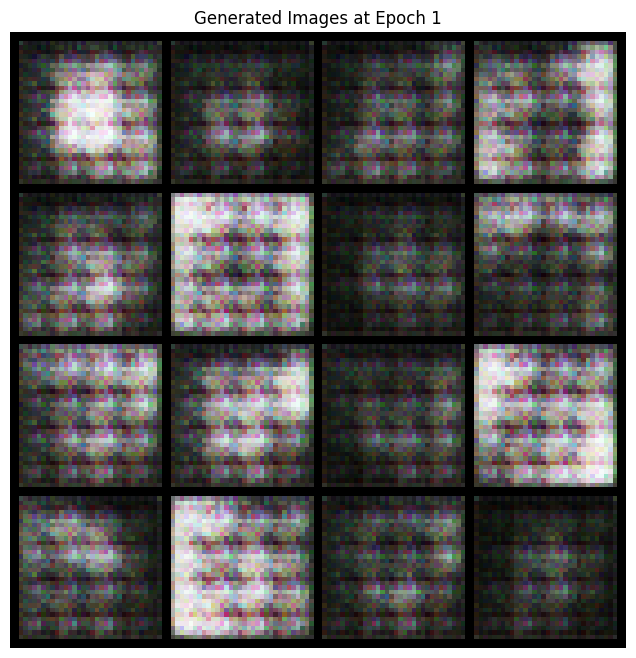

Epoch [2/50] D Loss: 0.9468, G Loss: 2.1471
Epoch [3/50] D Loss: 0.9582, G Loss: 2.0388
Epoch [4/50] D Loss: 0.9701, G Loss: 1.7945
Epoch [5/50] D Loss: 1.0402, G Loss: 1.5022
Epoch [6/50] D Loss: 0.9964, G Loss: 1.4890
Epoch [7/50] D Loss: 1.0096, G Loss: 1.5157
Epoch [8/50] D Loss: 0.9683, G Loss: 1.5066
Epoch [9/50] D Loss: 0.9465, G Loss: 1.5201
Epoch [10/50] D Loss: 0.9554, G Loss: 1.5390


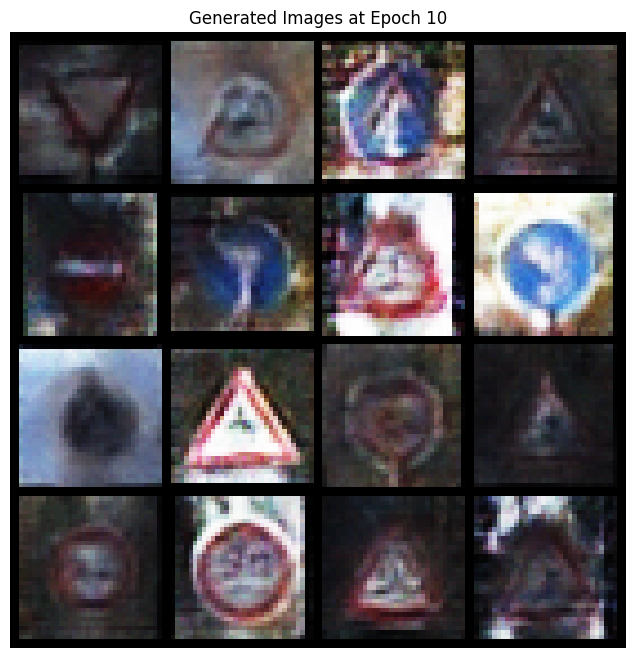

Epoch [11/50] D Loss: 0.9497, G Loss: 1.5351
Epoch [12/50] D Loss: 0.9856, G Loss: 1.5399
Epoch [13/50] D Loss: 0.9600, G Loss: 1.5451
Epoch [14/50] D Loss: 0.9531, G Loss: 1.5292
Epoch [15/50] D Loss: 0.9461, G Loss: 1.5626
Epoch [16/50] D Loss: 0.9802, G Loss: 1.5698
Epoch [17/50] D Loss: 0.9034, G Loss: 1.5831
Epoch [18/50] D Loss: 0.9477, G Loss: 1.5949
Epoch [19/50] D Loss: 0.9265, G Loss: 1.6203
Epoch [20/50] D Loss: 0.9112, G Loss: 1.6337


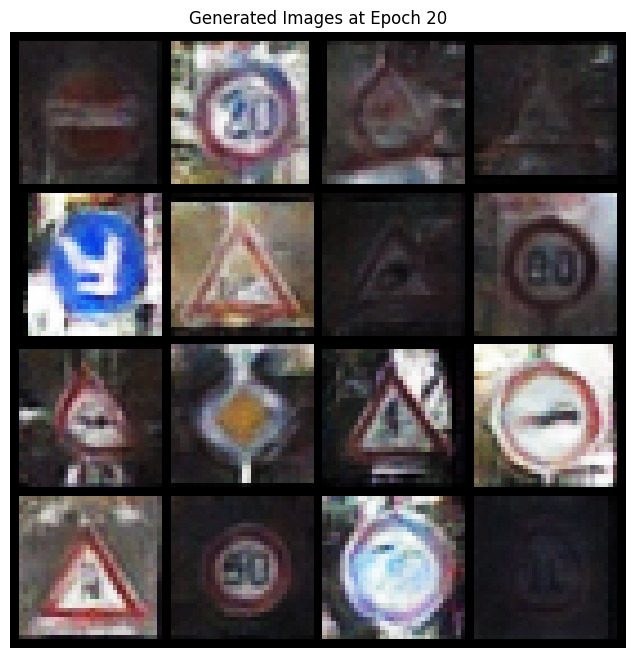

Epoch [21/50] D Loss: 0.9127, G Loss: 1.6328
Epoch [22/50] D Loss: 0.9214, G Loss: 1.6499
Epoch [23/50] D Loss: 0.8971, G Loss: 1.6987
Epoch [24/50] D Loss: 0.9226, G Loss: 1.6929
Epoch [25/50] D Loss: 0.8635, G Loss: 1.7111
Epoch [26/50] D Loss: 0.9584, G Loss: 1.6435
Epoch [27/50] D Loss: 0.8797, G Loss: 1.7117
Epoch [28/50] D Loss: 0.8825, G Loss: 1.7173
Epoch [29/50] D Loss: 0.9369, G Loss: 1.6933
Epoch [30/50] D Loss: 0.8780, G Loss: 1.7339


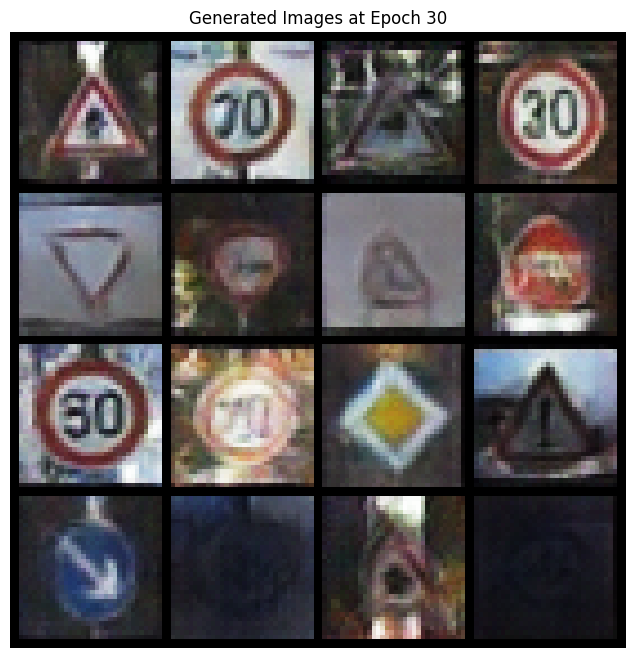

Epoch [31/50] D Loss: 0.9045, G Loss: 1.7081
Epoch [32/50] D Loss: 0.8960, G Loss: 1.7217
Epoch [33/50] D Loss: 0.8852, G Loss: 1.7418
Epoch [34/50] D Loss: 0.9066, G Loss: 1.7249
Epoch [35/50] D Loss: 0.9020, G Loss: 1.7352
Epoch [36/50] D Loss: 0.8540, G Loss: 1.7568
Epoch [37/50] D Loss: 0.9951, G Loss: 1.6767
Epoch [38/50] D Loss: 0.8475, G Loss: 1.7430
Epoch [39/50] D Loss: 0.8891, G Loss: 1.7563
Epoch [40/50] D Loss: 0.8837, G Loss: 1.7477


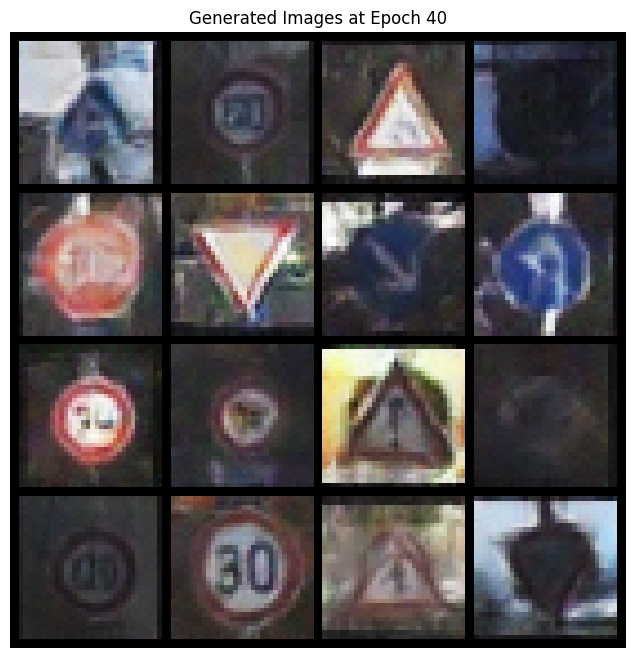

Epoch [41/50] D Loss: 0.8765, G Loss: 1.7688
Epoch [42/50] D Loss: 0.8728, G Loss: 1.7968
Epoch [43/50] D Loss: 0.8808, G Loss: 1.7941
Epoch [44/50] D Loss: 0.8996, G Loss: 1.8082
Epoch [45/50] D Loss: 0.8649, G Loss: 1.7864
Epoch [46/50] D Loss: 0.8915, G Loss: 1.7797
Epoch [47/50] D Loss: 0.8305, G Loss: 1.8327
Epoch [48/50] D Loss: 0.8766, G Loss: 1.8289
Epoch [49/50] D Loss: 0.8583, G Loss: 1.8226
Epoch [50/50] D Loss: 0.8513, G Loss: 1.8584


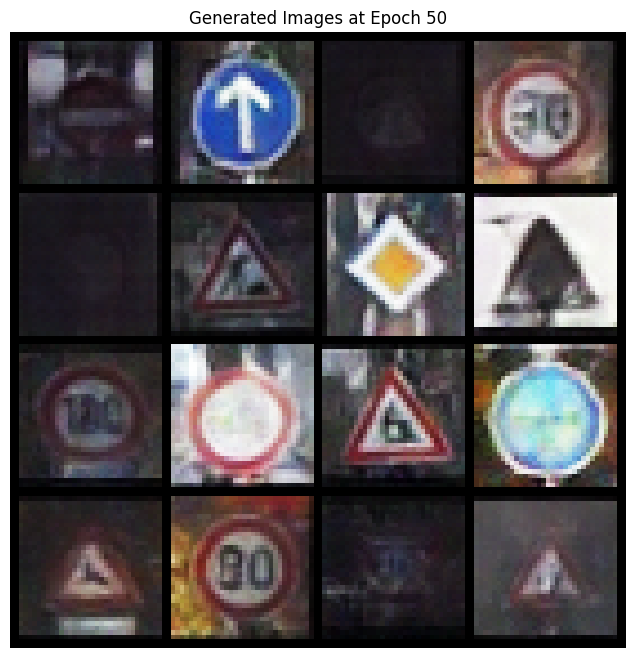

Final FID Score: 172.79


In [84]:
train_gan(train_loader, val_loader)

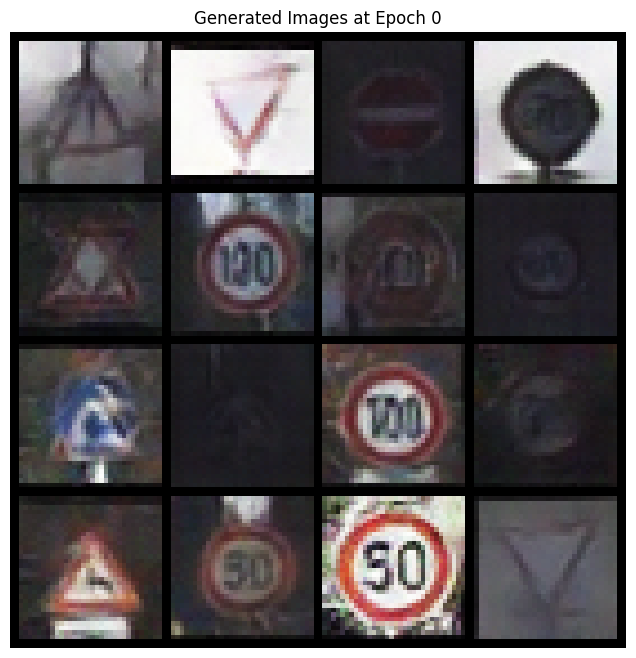

In [86]:
generator.eval()

num_images = 1000
batch_size = 100
generated_imgs = []

with torch.no_grad():
    for _ in range(num_images // batch_size):
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        generated_imgs.append(fake_imgs.cpu())

generated_imgs = torch.cat(generated_imgs, dim=0)

generated_imgs = generated_imgs[:num_images]

output_file = "/content/drive/MyDrive/piatek_Chmielewski_Ryszka.pt"
torch.save(generated_imgs.cpu().detach(), output_file)

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

show_generated_images(generated_imgs, 0)